# Exercise 9 Xarray and CartoPy: Sea-surface height and red tides

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/aselshall/eds/HEAD)

---

In [1]:
#pip install cdsapi

In [2]:
#pip install statsmodels

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

---

## 1. Problem Statement

The hypothesis is that high sea-level anomalies in the Gulf of Mexico is a  a necessary condition for the occurance of red tides (high concentration of K. brevis cell counts) in the West Florida shielf. High sea-level anomalies is asscoiated with the Gulf Loop Current, which is a warm ocean current that flows from the Caribbean to the Gulf of Mexico, then loops east and south along the Florida coast, and exits through the Straits of Florida. To investigate the relationship between sea level anomalies (SLA) and red tide occurrences (K. brevis cell counts), we you can employ several statistical methods such as time series analysis, regression analysis, event study analysis, spatial correlation analysis and machine learning models. The objective of this exercise is to prepare data for analysis. Specifically, our tasks are to:
- download and reduce monthly 3d (x,y, time) SLA data to monthly 2d (x, time) data
- download and reduce daily 3d (x,y, time) K. brevis data to weekly 1d (time) data
- Redue monthly 2D (x, time) sla data into to weekly 1d (time) data with temporal alignment with K. brevis data
- transform weekly 1d SLA and K. brevs data with techniques for stationarity, detrending, zero mean, normalization, etc.

This is all needed so the we you can directly compare SLA data with K. brevis cell count data and perform statstical analysis.

## 2. Exploring SLA data

### 2.1 Download global data (*optional*)

From [Climate Data Store (CDS)](https://cds.climate.copernicus.eu/#!/home) you can download the [Sea level gridded data from satellite observations for the global ocean from 1993 to present](
https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-globa). You can manually download the data from CDS website or through API. This [link](
https://cds.climate.copernicus.eu/api-how-to#install-the-cds-api-ke) contains information on how to use the CDS API and API key. Additional information can be found in this [link](https://confluence.ecmwf.int/display/CKB/How+to+install+and+use+CDS+API+on+Windows).

To run the code below, you need first to set the CDS API key.

In [4]:
# import cdsapi

# c = cdsapi.Client()

# c.retrieve(
#     'satellite-sea-level-global',
#     {
#         'version': 'vDT2021',
#         'format': 'zip',
#         'variable': 'monthly_mean',
#         'year': [
#             '1993', '1994', '1995',
#             '1996', '1997', '1998',
#             '1999', '2000', '2001',
#             '2002', '2003', '2004',
#             '2005', '2006', '2007',
#             '2008', '2009', '2010',
#             '2011', '2012', '2013',
#             '2014', '2015', '2016',
#             '2017', '2018', '2019',
#             '2020', '2021', '2022',
#             '2023',
#         ],
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#         ],
#     },
#     'download.zip')

### 2.2 Select and save Gulf of Mexico data (*optional*)

We need to extract the Gulf of Mexico data from this global dataset as follows.

In [5]:
# # Read all files
# ds = xr.open_mfdataset("Data/zos/hist/global/*.nc", combine="by_coords")  # , parallel=True

In [6]:
# # Display dataset
# ds

In [7]:
#ds.attrs

In [8]:
# # label-based selection to extract 'sla' data from the 'ds' DataSet.
# subset=ds.sla.sel(
#     latitude=slice(18,32), # South to North
#     longitude=slice(360-100, 360-75)) #West to East

# # Display slice 
# plt.figure(figsize=(10, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())
# subset[0,:,:].plot()
# ax.coastlines()

# # Write the DataArray to a netCDF file
# subset.to_netcdf('Data/zos/hist/dt_FL_twosat_phy_l4_199303_202305_vDT2021-M01.nc')

### 2.3 Load and display data

Load SLA data in the Gulf of Mexico from 1993-03 to 2023-05. The data file is provided with this exercise, so you do not need to use the codes in Sections 2.1 and 2.2.

In [9]:
# Read the netCDF file into a DataArray
ds = xr.open_dataset('Data/zos/hist/dt_FL_twosat_phy_l4_199303_202305_vDT2021-M01.nc')

ds

<xarray.Dataset> Size: 16MB
Dimensions:    (time: 364, latitude: 56, longitude: 100)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1993-02-15 1993-03-15 ... 2023-05-15
  * latitude   (latitude) float32 224B 18.12 18.38 18.62 ... 31.38 31.62 31.88
  * longitude  (longitude) float32 400B 260.1 260.4 260.6 ... 284.4 284.6 284.9
Data variables:
    sla        (time, latitude, longitude) float64 16MB ...

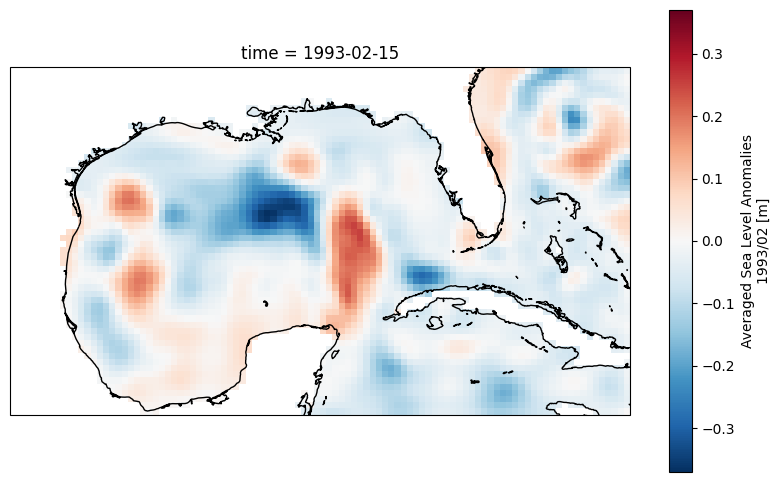

In [10]:
# Display 2d data  at the first time step
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ds.sla[0,:,:].plot()
ax.coastlines();

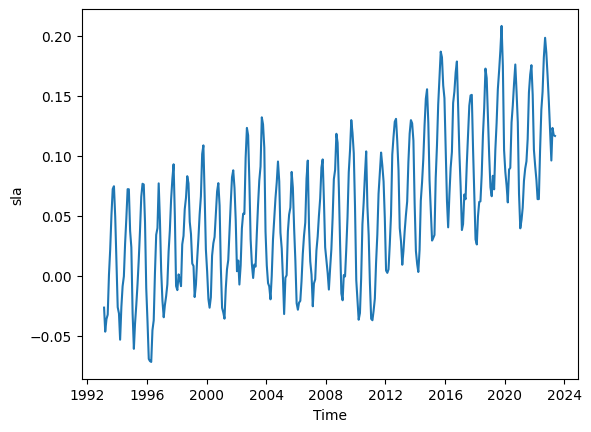

In [11]:
# Calculate the mean SLA across the 'latitude' and 'longitude' dimensions
mean_sla = ds.sla.mean(dim=('latitude', 'longitude')).plot()

In [12]:
#Let us learn more about SLA
ds.sla.attrs

{'cell_methods': 'time: mean within years',
 'grid_mapping': 'crs',
 'long_name': 'Averaged Sea Level Anomalies 1993/02',
 'standard_name': 'sea_surface_height_above_sea_level',
 'units': 'm'}

The above DataSet `ds` is monthly. Let us increase temporal resolution to weekly using interpolation `.interp`.

<xarray.Dataset> Size: 71MB
Dimensions:    (latitude: 56, longitude: 100, time: 1578)
Coordinates:
  * latitude   (latitude) float32 224B 18.12 18.38 18.62 ... 31.38 31.62 31.88
  * longitude  (longitude) float32 400B 260.1 260.4 260.6 ... 284.4 284.6 284.9
  * time       (time) datetime64[ns] 13kB 1993-02-21 1993-02-28 ... 2023-05-14
Data variables:
    sla        (time, latitude, longitude) float64 71MB nan nan ... 0.06263

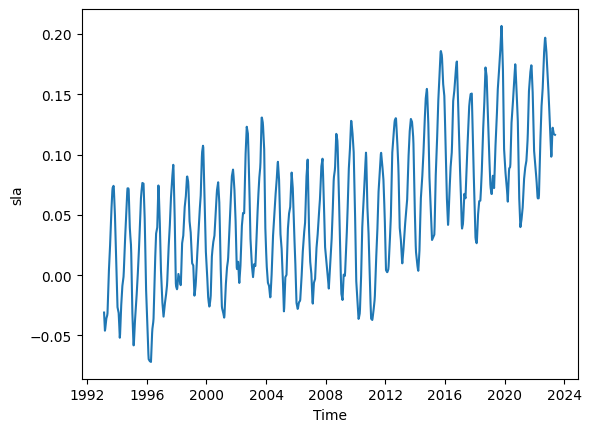

In [13]:
# Create a new time coordinate with weekly frequency
weekly_dates = pd.date_range(start=ds.time.values[0], end=ds.time.values[-1], freq='W')

# Interpolate the DataArray to weekly values
ds_weekly = ds.interp(time=weekly_dates).copy()

# Plot our high temporal resolution data
ds_weekly.sla.mean(dim=('latitude', 'longitude')).plot()

# Display our high temporal resolution data
ds_weekly

Note from monthly to weekly, the number of time cooridnates 364 to 1578.

### 2.4 Generate cooridnates along trackline 26

According to [Weisberg et al., 2014](https://doi.org/10.1016/j.hal.2014.04.010) we can establish a correlation between sea-level anomalies in the Gulf of Mexico and the occurrence of red tides (high concentrations of K. brevis cell counts) in the West Florida Shelf through trackine 26 with the following start and end points in the code below.To increase spatial resolution, let us calculate intermediate points along the start and end points of trackine 26, and store them in a NumPy array.Let us to do 100 points along trackine 26 and find the latitude and longitudes of these 100 points.

In [14]:
# This code is generated by ChatGPT 3.5
# Define the start and end points
start_point = (-85.79403277044844, 28.44874852567387)
end_point = (-83.61900543369907, 23.84111494192613)

# Calculate the distance between the two points using Vincenty's formulae
def vincenty_distance(lat1, lon1, lat2, lon2):
    earth_radius = 6371  # Earth's radius in kilometers
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi/2) * math.sin(delta_phi/2) + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2) * math.sin(delta_lambda/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = earth_radius * c

    return distance

total_distance = vincenty_distance(start_point[1], start_point[0], end_point[1], end_point[0])

# Calculate intermediate points and store them in a NumPy array
num_points = 100
intermediate_points = np.zeros((num_points, 2))  # Initialize a NumPy array to store the points

for i in range(num_points):
    ratio = (i + 1) / (num_points + 1)
    intermediate_lat = start_point[0] + (end_point[0] - start_point[0]) * ratio
    intermediate_lon = start_point[1] + (end_point[1] - start_point[1]) * ratio
    intermediate_points[i] = [intermediate_lat, intermediate_lon]

print('intermediate_points has shape', intermediate_points.shape)
print('Start point',intermediate_points[0])
print('End point',intermediate_points[-1])

intermediate_points has shape (100, 2)
Start point [-85.77249785  28.40312839]
End point [-83.64054036  23.88673508]


We will convert the longitude coordinates from the -180 to 180 convention to the 0 to 360 convention to make the coordinates of our 100 points along trackline 26 consistant with the SLA data.

In [15]:
# Make coordinate of 100 points aling trackine 26 consistant with SLA data
points= intermediate_points.copy()
points[:, 0] += 360 # Add 360 to the first column
points[:, [0, 1]] = points[:, [1, 0]] # Swap the columns
print(points.shape)
print('latitudes, longitudes')
print(points[0])
print(points[-1])

(100, 2)
latitudes, longitudes
[ 28.40312839 274.22750215]
[ 23.88673508 276.35945964]


### 2.5 Plot trackline 

Let us plot our trackline 26 and shown the the background either SLA data or bathymetry lines.

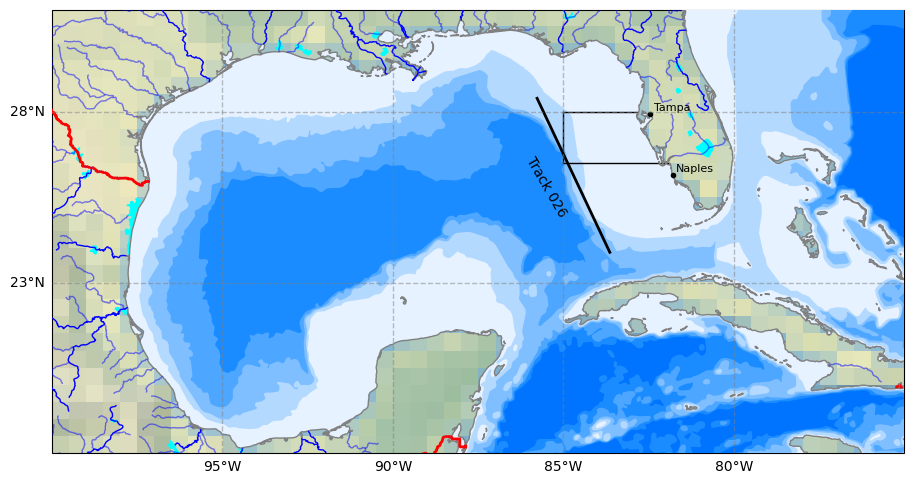

In [16]:
# 0) Select data to plot
Plot_Num= 2  #Type 1 to plot SLA data for the first time step or 2 to plot bathymetry lines

# 1) Select plot extend: Lon_West, Lon_East, Lat_South, Lat_North in Degrees
extent = [-75, -100, 18, 31] 

# 2) Select projection
projPC = ccrs.PlateCarree()

# 3) Create figure
fig = plt.figure(figsize=(11, 8.5))
#plt.subplots_adjust(hspace=0.1, wspace=0.2)  # Adjust the height and width spaces between subplots

# 4) Loop to plot variables 
variable = 'sla'
colormap = 'coolwarm'
title=''

# 5) Create Axes     
ax = plt.subplot(1, 1, 1, projection=projPC)

# 6) Setting the extent of the plot
ax.set_extent(extent, crs=projPC)

# 7) Add plot title 
ax.set_title(title, fontsize=10, loc='left')

# 8) Add gridlines (we need to cutomize grid lines to improve visualization)                              
gl = ax.gridlines(draw_labels=True, xlocs=np.arange(extent[1],extent[0], 5), ylocs= np.arange(extent[2], extent[3], 5),
                  linewidth=1, color='gray', alpha=0.5, linestyle='--',  zorder=40)

gl.right_labels = False  # 
gl.top_labels = False    # Set the font size for x-axis labels
gl.xlabel_style = {'size': 10}  # Set the font size for x-axis labels
gl.ylabel_style = {'size': 10}  # Set the font size for y-axis labels

# 9) Adding Natural Earth features
## Pre-defined features
ax.set_facecolor(cfeature.COLORS['water'])  #Blackgroundwater color for the ocean
#ax.add_feature(cfeature.LAND.with_scale('10m'), zorder=20) 
ax.add_feature(cfeature.LAKES.with_scale('10m'), color='aqua', zorder=21) 
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color='gray', zorder=21) 
ax.add_feature(cfeature.BORDERS, edgecolor='red',facecolor='none', linewidth=2, zorder=22) 
ax.stock_img()

## General features (not pre-defined)
ax.add_feature(cfeature.NaturalEarthFeature(
    'physical', 'rivers_lake_centerlines', scale='10m', edgecolor='blue', facecolor='none') ,zorder=21)
ax.add_feature(cfeature.NaturalEarthFeature(
    'physical','rivers_north_america', scale='10m', edgecolor='blue', facecolor='none', alpha=0.5),zorder=21)

# 10) Adding user-defined features 
# Plot site area on GeoAxes given lon and lat coordinates in first subplot 
ax.plot([-85.0, -85.0], [26.5, 28.0], color='black', linewidth=1, zorder = 15)  
ax.plot([-85.0, -82.85], [28.0, 28.0], color='black', linewidth=1, zorder = 15)
ax.plot([-85.0, -81.9], [26.5, 26.5], color='black', linewidth=1, zorder = 15)

## Plot Track 026 line on GeoAxex and annotate with text using axes cooridnates in second subplot
#points = np.array([[-85.7940, 28.4487], [-83.6190, 23.8411]]) 
ax.plot(intermediate_points[:,0],intermediate_points[:,1], color='black', linewidth=2, zorder = 15)
ax.text(0.58, 0.6, 'Track 026', transform=ax.transAxes, 
        color='black', fontsize=10,  ha='center',  va='center',  rotation=300, zorder = 15)

## Adding names and locations of major cities
locations_coordinates = {"Tampa": [27.9506, -82.4572], 
                     #"Sarasota": [27.3364, -82.5307], 
                     #"Fort Myers": [26.6406, -81.8723], 
                     "Naples": [26.142, -81.7948]}
for location, coordinates in locations_coordinates.items():
    ax.plot(coordinates[1], coordinates[0],  
            transform=ccrs.PlateCarree(),  marker='o', color='black', markersize=3, zorder = 22)
    ax.text(coordinates[1] + 0.1, coordinates[0] + 0.1, 
            location, transform=ccrs.PlateCarree(), color='black', fontsize=8, zorder = 22)

# 11) Adding raster data and colorbar for the first three subplots
if Plot_Num ==1:
    # dataplot = ax.contourf(da.latitude, da.longitude, da.sla[0,:,:], 
    #                        cmap=colormap, zorder=12, transform=ccrs.PlateCarree())
    dataplot = ax.contourf(ds.longitude, ds.latitude, ds.sla[0,:,:], 
                           cmap=colormap, zorder=12, transform=ccrs.PlateCarree())
    colorbar = plt.colorbar(dataplot, orientation='horizontal', pad=0.1, shrink=1)  
    colorbar.set_label(ds.sla.attrs['standard_name'], fontsize=10)

#12) Plot 6 bathymetry lines using a loop
if Plot_Num == 2:
    # Names of bathymetry line 
    bathymetry_names = ['bathymetry_L_0', 'bathymetry_K_200', 
                        'bathymetry_J_1000', 'bathymetry_I_2000', 
                        'bathymetry_H_3000', 'bathymetry_G_4000'] 
    
    # Very light blue to light blue generated by ChatGPT 3.5 Turbo
    colors = [(0.9, 0.95, 1), (0.7, 0.85, 1), 
              (0.5, 0.75, 1), (0.3, 0.65, 1), 
              (0.1, 0.55, 1), (0, 0.45, 1), ]  
    
    # Loop to plot each bathymetry line
    for bathymetry_name, color in zip(bathymetry_names, colors):
        ax.add_feature(
            cfeature.NaturalEarthFeature(
                category='physical', 
                name=bathymetry_name, 
                scale='10m', 
                edgecolor='none', 
                facecolor=color), 
            zorder = 11)


### 2.6 Extract SLA data along trackline 26 

At each time step, we will determine the SLA values along track 26 using interpolation, effectively converting 3D SLA data into 2D. 

Initially, we will create a new DataSet called `ds_TL26` with dimensions 'latitude' and 'time'. Notably, 'longitude' is aligned with 'latitude', making this a line data rather than grid data. For details, check "Section 2.3.3 Dataset with aligined coordinates (advanced)" in Xarray lesson. We will start by populating this area with NaN values. Subsequently, we will fill it with SLA data interpolated from the `ds` dataset.

In [17]:
# Create coordinates for the four labels
time = ds.time
latitudes= points[:,0]  # latitude values 
longitudes= points[:,1]  # longitude values 

# Create a 4D Numpy Array representing values  for a 2x3x4x5 grid
size=(len(time), len(latitudes))
sla = np.full(size, np.nan) #sea surface anomoly [m]

# Create a DataArray with zos values
ds_TL26 = xr.Dataset(
    {'sla': (('time', 'latitude'), sla)}, #sla values and its dimensions   
    coords={'time': time, 'latitude': latitudes}) #Coordinates

# Data long data with dim lat data for records
ds_TL26.coords['longitude'] = ('latitude', longitudes)

# Add metadata to the DataArray
ds_TL26.sla.attrs['Long Name'] = 'sea_surface_anomoly'
ds_TL26.sla.attrs['Short Name'] = 'sla'
ds_TL26.sla.attrs['Units'] = 'meters'
ds_TL26.sla.attrs['Description'] = "Sea surface anomoly along trackline 26 "

# Displaying DataSet with labeled dimensions and coordinates, and metadata
display(ds_TL26)

<xarray.Dataset> Size: 296kB
Dimensions:    (time: 364, latitude: 100)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1993-02-15 1993-03-15 ... 2023-05-15
  * latitude   (latitude) float64 800B 28.4 28.36 28.31 ... 23.98 23.93 23.89
    longitude  (latitude) float64 800B 274.2 274.2 274.3 ... 276.3 276.3 276.4
Data variables:
    sla        (time, latitude) float64 291kB nan nan nan nan ... nan nan nan

Next, we will populate `ds_TL26` with SLA data interpolated from the `ds` dataset by leveraging broadcasting. While we have not covered broadcasting, this example will help you to understand how powerful broadcasting is.

Although you could fill `ds_TL26` with data using a for-loop, this approach would be highly computationally intensive. Imagine looping 364 (number of longitudes) x 100 (number of time steps) times and carrying out interpolation in each iteration!

In [18]:
# You can create a grid of coordinates for which you want to interpolate values
time_coords = ds_TL26.time
latitude_coords = ds_TL26.latitude
longitude_coords = ds_TL26.longitude

# Use meshgrid to create a full grid of (time, latitude, longitude)
time_grid, lat_grid, lon_grid = xr.broadcast(time_coords, latitude_coords, longitude_coords)

# Interpolate using the interp method over the entire grid
interpolated_ds = ds.sla.interp(time=time_grid, latitude=lat_grid, longitude=lon_grid, method='linear')

# Now interpolated_ds contains the interpolated values for the entire grid
# Assuming that the original shape of ds_TL26.sla is compatible, you can assign the values directly
ds_TL26['sla'] = interpolated_ds

ds_TL26.sla

<xarray.DataArray 'sla' (time: 364, latitude: 100)> Size: 291kB
array([[-0.04606196, -0.04382741, -0.04098129, ..., -0.18760819,
        -0.20198027, -0.21718859],
       [-0.07241661, -0.07066914, -0.06829647, ..., -0.20055153,
        -0.20169734, -0.20318583],
       [-0.03172363, -0.02991171, -0.02928312, ..., -0.16815929,
        -0.1697745 , -0.17070123],
       ...,
       [ 0.09914508,  0.1030116 ,  0.10520716, ..., -0.01598656,
        -0.02282683, -0.02975827],
       [ 0.09877273,  0.10183734,  0.10362421, ..., -0.03444734,
        -0.04470912, -0.05566252],
       [ 0.08704669,  0.0877758 ,  0.08854079, ...,  0.28771283,
         0.30058475,  0.31296625]])
Coordinates:
  * time       (time) datetime64[ns] 3kB 1993-02-15 1993-03-15 ... 2023-05-15
  * latitude   (latitude) float64 800B 28.4 28.36 28.31 ... 23.98 23.93 23.89
    longitude  (latitude) float64 800B 274.2 274.2 274.3 ... 276.3 276.3 276.4
Attributes:
    cell_methods:   time: mean within years
    grid_mapping:   crs
    long_name:      Averaged Sea Level Anomalies 1993/02
    standard_name:  sea_surface_height_above_sea_level
    units:          m

### 2.7 Plot SLA data along trackline 26

Now let us plot SLA values along trackine 26 for all time steps. We have convert 3d to 2d that can be visualized. Let us see if we can reproduce Figure 4 in [Weisberg et al., 2014](https://doi.org/10.1016/j.hal.2014.04.010)


(364, 100) (364, 100) <xarray.DataArray 'sla' (time: 364, latitude: 100)> Size: 291kB
array([[-0.04606196, -0.04382741, -0.04098129, ..., -0.18760819,
        -0.20198027, -0.21718859],
       [-0.07241661, -0.07066914, -0.06829647, ..., -0.20055153,
        -0.20169734, -0.20318583],
       [-0.03172363, -0.02991171, -0.02928312, ..., -0.16815929,
        -0.1697745 , -0.17070123],
       ...,
       [ 0.09914508,  0.1030116 ,  0.10520716, ..., -0.01598656,
        -0.02282683, -0.02975827],
       [ 0.09877273,  0.10183734,  0.10362421, ..., -0.03444734,
        -0.04470912, -0.05566252],
       [ 0.08704669,  0.0877758 ,  0.08854079, ...,  0.28771283,
         0.30058475,  0.31296625]])
Coordinates:
  * time       (time) datetime64[ns] 3kB 1993-02-15 1993-03-15 ... 2023-05-15
  * latitude   (latitude) float64 800B 28.4 28.36 28.31 ... 23.98 23.93 23.89
    longitude  (latitude) float64 800B 274.2 274.2 274.3 ... 276.3 276.3 276.4
Attributes:
    cell_methods:   time: mean within yea

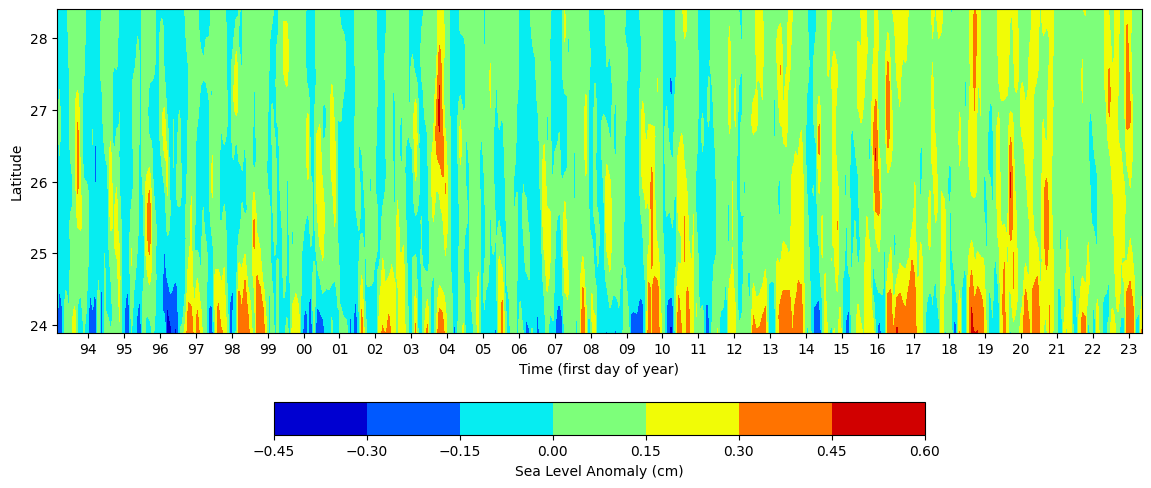

In [19]:
# Create a grid of time and latitude values for contour plot
lat_grid, time_grid = np.meshgrid(ds_TL26.latitude,ds_TL26.time,)
print(time_grid.shape, lat_grid.shape,ds_TL26.sla)

# Create a Figure and Axes object
fig, ax = plt.subplots(figsize=(14, 6))

# Create the contour plot
contour = ax.contourf(time_grid,lat_grid, ds_TL26.sla, cmap='jet')

# Add colorbar
cbar = fig.colorbar(contour, ax=ax, orientation='horizontal',shrink=0.6)
cbar.set_label('Sea Level Anomaly (cm)')

# Set labels and title
ax.set_xlabel('Time (first day of year)')
ax.set_ylabel('Latitude')
#ax.set_title('Sea Level Anomaly')

# Format x-axis tick labels to display only last two digits of the year
import matplotlib.dates as mdates

# Set x-axis major locator and formatter to show ticks and labels for every year
years = mdates.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))  # Use '%y' to display only the last two digits of the year



## 3. Exploring K. brevis data

Red tides are caused by Karenia brevis harmful algae blooms. For Karenia brevis cell count data, you can use the [current dataset](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0120767) of Physical and biological data collected along the Texas, Mississippi, Alabama, and Florida Gulf coasts in the Gulf of Mexico as part of the Harmful Algal BloomS Observing System from 1953-08-19 to 2023-07-06 (NCEI Accession 0120767). For direct data download, you can use this [data link](https://www.nodc.noaa.gov/archive/arc0069/0120767/7.7/data/0-data/habsos_20230714.csv) and this [data documentation link](https://www.nodc.noaa.gov/archive/arc0069/0120767/7.7/data/0-data/Support%20Documents/).  Alternatively, FWRI documents Karenia brevis blooms from 1953 to the present. The dataset has more than 200,000 records is updated daily. To request this dataset email: HABdata@MyFWC.com. To learn more about this data, check the [FWRI  Red Tide  Red Tide Current Status](https://myfwc.com/research/redtide/statewide/).

### 3.1 Extract K. brevis data for West Florida shielf

We will conduct our analysis along the West Florida shielf covering from Tampa Bay and Charlotte Harbor estuary. For Tampa Bay, we restrict the K. brevis measurements from 27° N to 28° N and 85° W to coast. For Charlotte Harbor estuary, we restrict the K. brevis measurements from 25.5° N to less than 27° N and 85° W to coast. For each time step, which  is one week, we will take spatial average and thus convert our daily 3d K brevis cell count data to a weekly 1d data. 

In [20]:
# Read a csv file with Pandas
df = pd.read_csv('Data/habsos_20230714.csv', low_memory=False)

# Select column names that you need for your analysis (e.g., 'LATITUDE', 'LONGITUDE', 'SAMPLE_DATE', 'CELLCOUNT', etc.) 
selected_columns = ['STATE_ID','DESCRIPTION','LATITUDE', 'LONGITUDE', 'SAMPLE_DATE', 'CELLCOUNT']

# Filter the DataFrame to include only the selected columns
df = df[selected_columns]

# Create a new column 'region' with default value 'Other'
df['REGION'] = 'Other'

# Mask for dicing: Define mask for Tampa Bay region based on latitude and longitude values
tampa_bay_mask = (df['LATITUDE'] >= 27) & (df['LATITUDE'] <= 28) & (df['LONGITUDE'] >= -85)

# Assign value 'Tampa Bay' to rows matching Tampa Bay mask 
df.loc[tampa_bay_mask, 'REGION'] = 'Tampa Bay'

# Mask for decing: Define mask for Charlotte Harbor estuary region  based on latitude and longitude values
charlotte_harbor_mask = (df['LATITUDE'] >= 25.5) & (df['LATITUDE'] < 27) & (df['LONGITUDE'] >= -85)

# Assign value 'Charlotte Harbor' to rows matching Charlotte Harbor mask
df.loc[charlotte_harbor_mask, 'REGION'] = 'Charlotte Harbor'

# Convert the "SAMPLE_DATE" column to datetime format using pd.to_datetime()
df['SAMPLE_DATE'] = pd.to_datetime(df['SAMPLE_DATE'])

# Set the "SAMPLE_DATE" column as the index of your DataFrame
df.set_index('SAMPLE_DATE', inplace=True)

#Sort index (optional step)
df.sort_index(inplace=True)

df

,STATE_ID,DESCRIPTION,LATITUDE,LONGITUDE,CELLCOUNT,REGION
SAMPLE_DATE,,,,,,
1953-08-19 00:00:00,FL,Tom Adams Bridge (Lemon Bay),26.93450,-82.3535,116000,Charlotte Harbor
1953-08-26 00:00:00,FL,Cortez Bridge,27.46840,-82.6937,178000,Tampa Bay
1953-08-26 00:00:00,FL,Naples Pier,26.13163,-81.8063,0,Charlotte Harbor
1953-08-26 00:00:00,FL,Piney Point; Lee County,26.53340,-81.9796,0,Charlotte Harbor
1953-09-03 00:00:00,FL,Sarasota Bay; 3 mi North of bridge,27.37750,-82.5708,1732000,Tampa Bay
...,...,...,...,...,...,...
2023-07-05 16:08:00,AL,Dauphin Island Public Beach,30.24780,-88.1272,0,Other
2023-07-05 16:11:00,AL,Cotton Bayou,30.26940,-87.5820,0,Other
2023-07-05 16:27:00,AL,Florida Point A,30.26620,-87.5501,0,Other


### 3.2 Transform 3d daily K. brevis data to 1d weekly data

For each time step that is one week, let us take the spatial average to convert our daily 3d K brevis cell count data to a weekly 1d data. 

In [21]:
#Get rows for charlotte harbor region
#For these rows, find the mean cellcount per week for the study period 
charlotte_harbor_data = df[df['REGION'] == 'Charlotte Harbor'].copy()
print('Charlotte Harbor data', charlotte_harbor_data.shape)
charlotte_harbor_data = charlotte_harbor_data['CELLCOUNT'].resample('W').mean()
print('Charlotte Harbor weekly cell count data', charlotte_harbor_data.shape)

#Get rows for tampa bay region 
#For these rows find the maximum cellcount per week for the study period 
tampa_bay_data = df[df['REGION'] ==  'Tampa Bay'].copy()
print('Tampa Bay data', tampa_bay_data.shape)
tampa_bay_data = tampa_bay_data['CELLCOUNT'].resample('W').mean()
print('Tampa Bay weekly cell count data', tampa_bay_data.shape)

#Get rows for West FL region 
#For these rows find the maximum cellcount per week for the study period 
mask=(df['REGION'] ==  'Tampa Bay') | (df['REGION'] ==  'Charlotte Harbor')
west_FL_data = df[mask].copy() 
print('West FL data:', west_FL_data.shape)
west_FL_data = west_FL_data['CELLCOUNT'].resample('W').mean()
print('West FL weekly cell count data:', west_FL_data.shape)

Charlotte Harbor data (61186, 6)
Charlotte Harbor weekly cell count data (3646,)
Tampa Bay data (89214, 6)
Tampa Bay weekly cell count data (3645,)
West FL data: (150400, 6)
West FL weekly cell count data: (3646,)


### 3.3 Plot weekly K. brevis data

We can now plot the weekly 1d K. brevis cell count data.

1993-02-15 00:00:00 2023-05-15 00:00:00
SAMPLE_DATE
1993-02-21   NaN
Freq: W-SUN, Name: CELLCOUNT, dtype: float64
SAMPLE_DATE
2023-05-14    2620.213115
Freq: W-SUN, Name: CELLCOUNT, dtype: float64


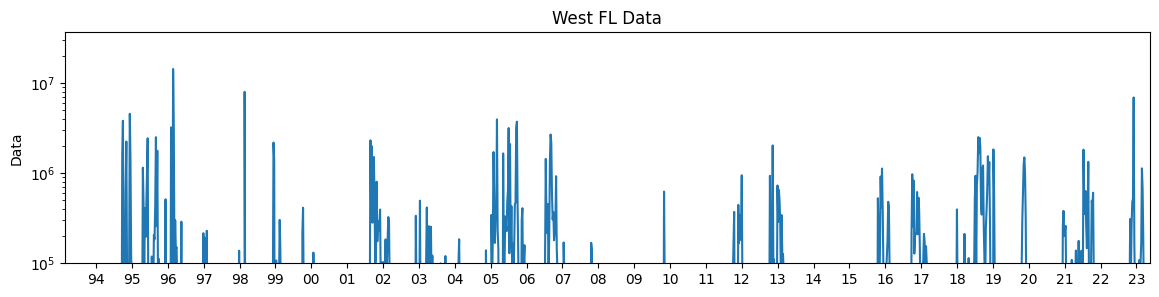

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(14, 3))

# Calculate the minimum and maximum values of the 'time' column in 'da'
min_time = pd.Timestamp(ds.time.min().values) 
max_time = pd.Timestamp(ds.time.max().values)
print(min_time, max_time)
    
# Plot west_FL_data from min_time to max_time
KB_data=west_FL_data.loc[min_time:max_time]
print(KB_data.head(1))
print(KB_data.tail(1))
ax.plot(KB_data, label='West FL')
ax.set_yscale('log')
ax.set_ylabel('Data')
ax.set_title('West FL Data')

# Set x-axis and y-axis limits
ax.set_xlim(min_time, max_time)
ax.set_ylim(1e5, None)

# Set x-axis major locator and formatter to show ticks and labels for every year
years = mdates.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set x-axis major locator and formatter to show ticks and labels for every year with two digits
years = mdates.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))


## 4. Transform SLA and K. brevis to prepare data for analysis

### 4.1 Temporal resolution alignment of SLA and k. brevis data 

We have weekly red tide data and monthly SLA data. We will need to aggregate or interpolate one of the datasets so that both series have the same temporal resolution. We 2d sla data with shape (364, 100). Let use do weekly interpolation. 

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 1578, latitude: 100)
Coordinates:
  * latitude   (latitude) float64 800B 28.4 28.36 28.31 ... 23.98 23.93 23.89
    longitude  (latitude) float64 800B 274.2 274.2 274.3 ... 276.3 276.3 276.4
  * time       (time) datetime64[ns] 13kB 1993-02-21 1993-02-28 ... 2023-05-14
Data variables:
    sla        (time, latitude) float64 1MB -0.05171 -0.04958 ... 0.2891 0.3007

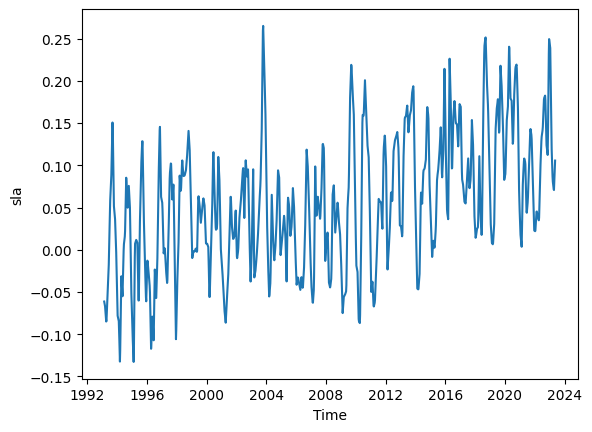

In [23]:
# Create a new time coordinate with weekly frequency
weekly_dates = pd.date_range(start=ds.time.values[0], end=ds.time.values[-1], freq='W')

# Interpolate the DataArray to weekly values
ds_TL26_HR = ds_TL26.interp(time=weekly_dates).copy()

# Plot and display the new high resolution (HR) dataset
ds_TL26_HR.sla.mean(dim=('latitude')).plot()
display(ds_TL26_HR)

### 4.2 Reduce 2D time series of SLA along trackline-26 to 1d time series

For the SLA data, we have values along a line. To match it with K. brevis data, we need to take an average or use some other method to reduce the 2D data to a 1D time series that we can directly compare with the K brevis data.

For simplicy we will take the mean SLA values from the first latitude value along trackline 26 at around 23.95 to latitde value of 24.6. The latitude value of 24.6 was visually estimated. However, this step can be iterative until we can establish a good correlation between weekly time series of SLA along trackline 26 and weekly time series of k. brevis cell-count data along the west Florida shelf. 

In [24]:
ds_TL26_HR

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 1578, latitude: 100)
Coordinates:
  * latitude   (latitude) float64 800B 28.4 28.36 28.31 ... 23.98 23.93 23.89
    longitude  (latitude) float64 800B 274.2 274.2 274.3 ... 276.3 276.3 276.4
  * time       (time) datetime64[ns] 13kB 1993-02-21 1993-02-28 ... 2023-05-14
Data variables:
    sla        (time, latitude) float64 1MB -0.05171 -0.04958 ... 0.2891 0.3007

To get the desired slice of latitudes from our `ds_TL26_HR` dataset, we can use the following approach:
- Find the index of the latitude value closest to our target value of 24.6 using the `numpy.argmin` function and the absolute difference between the latitude values and 26.
- Use the index to slice the dataset along the latitude dimension.

This approach will give you a subset of the dataset, `ds_TL26_HR_LowLat`, containing all latitudes from the minimum latitude up to and including the latitude closest to 24.6.


Low latitude starts from 23.887
Low latitude ends at 24.617 (closet to target latitude of 24.6)


Text(0, 0.5, 'Latitude')

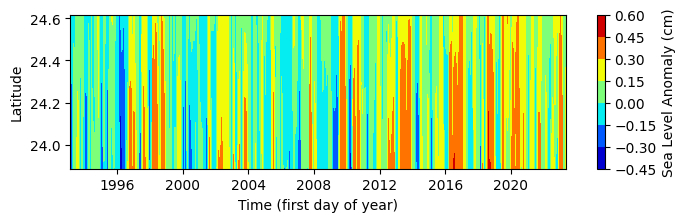

In [25]:
# Find the index of the latitude closest to target lat 24.8
target_lat = 24.6
idx_closest = np.argmin(np.abs(ds_TL26_HR.latitude.values - target_lat))

# Slice the dataset from the minimum latitude up to the index closest to 26
ds_TL26_HR_LowLat = ds_TL26_HR.isel(latitude=slice(idx_closest,len(ds_TL26_HR.latitude))).copy()
print(f'Low latitude starts from {np.round(ds_TL26_HR_LowLat.latitude.min().values,3)}')
print(f'Low latitude ends at {np.round(ds_TL26_HR_LowLat.latitude.max().values,3)} (closet to target latitude of {target_lat})')

#Plot low latitude slide
fig, ax= plt.subplots(figsize=(8, 2))
lat_grid, time_grid = np.meshgrid(ds_TL26_HR_LowLat.latitude,ds_TL26_HR_LowLat.time,)
contour = ax.contourf(time_grid, lat_grid, ds_TL26_HR_LowLat.sla, cmap='jet')
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Sea Level Anomaly (cm)')
ax.set_xlabel('Time (first day of year)')
ax.set_ylabel('Latitude')

We can simple take the mean at each time step to convert the 2d SLA data in the above figure to 1d data.

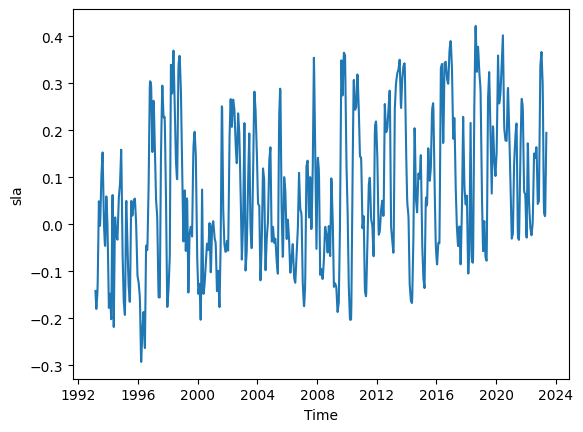

In [26]:
# Calculate the mean of the variable 'sla' along the 'latitude' dimension in the DataSet 'ds'
ds_TL26_HR_LowLat_mean = ds_TL26_HR_LowLat.sla.mean(dim='latitude').copy()

#Visualize the 1d weekly SLA time series
ds_TL26_HR_LowLat_mean.plot();

Let us plot both SLA and K. brevis data.

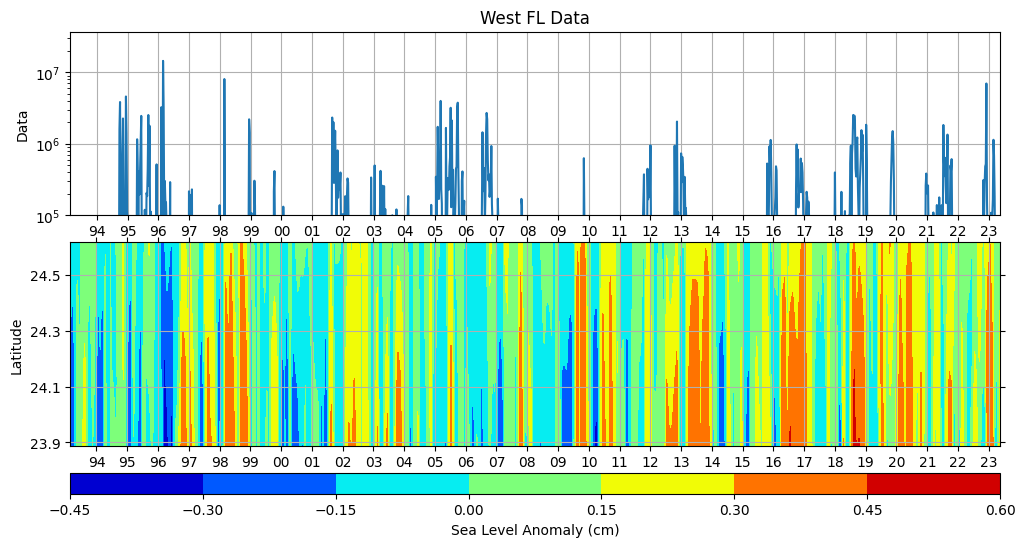

In [27]:
# Create a figure with two subplots sharing the x-axis
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 1, height_ratios=[45,50, 5])


# First subplot
# Create the line plot
ax_line = plt.subplot(gs[0])
ax_line.plot(KB_data, label='West FL')
ax_line.set_yscale('log')
ax_line.set_ylabel('Data')
ax_line.set_title('West FL Data')

# Set x-axis and y-axis limits
ax_line.set_xlim(min_time, max_time)
ax_line.set_ylim(1e5, None)

# Add gridlines to the plot
ax_line.grid(True, axis='x')
ax_line.grid(True, axis='y')

# Set x-axis major locator and formatter to show ticks and labels for every year with two digits
years = mdates.YearLocator()
ax_line.xaxis.set_major_locator(years)
ax_line.xaxis.set_major_formatter(mdates.DateFormatter('%y'))


# Second subplot
# Create a grid of time and latitude values for contour plot
lat_grid_HR, time_grid_HR = np.meshgrid(ds_TL26_HR_LowLat.latitude,ds_TL26_HR_LowLat.time,)

# Create the contour plot
ax_contour = plt.subplot(gs[1])
contour = ax_contour.contourf(time_grid_HR, lat_grid_HR, ds_TL26_HR_LowLat.sla, cmap='jet')

# Add gridlines to the plot
ax_contour.grid(True)

# Set labels and title
ax_contour.set_xlabel('Time (first day of year)')
ax_contour.set_ylabel('Latitude')

# Set x-axis major locator and formatter to show ticks and labels for every year with two digits
years = mdates.YearLocator()
ax_contour.xaxis.set_major_locator(years)
ax_contour.xaxis.set_major_formatter(mdates.DateFormatter('%y'))  # Use '%y' to display only the last two digits of the year

# Hide x-axis labels on the top axis
# Hide y-axis labels on the right axis
ax_contour.xaxis.set_tick_params(top=True, labeltop=False)
ax_contour.yaxis.set_tick_params(right=True, labelright=False)

# Set y-axis major locator and formatter to show ticks and labels for every 0.5
y_ticks = np.arange(23.5, 29, 0.2)
ax_contour.yaxis.set_major_locator(plt.FixedLocator(y_ticks))


# Add colorbar with decreased vertical distance
cbar_ax = plt.subplot(gs[2])
cbar = fig.colorbar(contour, cax=cbar_ax, orientation='horizontal', shrink=0.6)
cbar.set_label('Sea Level Anomaly (cm)')



Here are the two time series together.

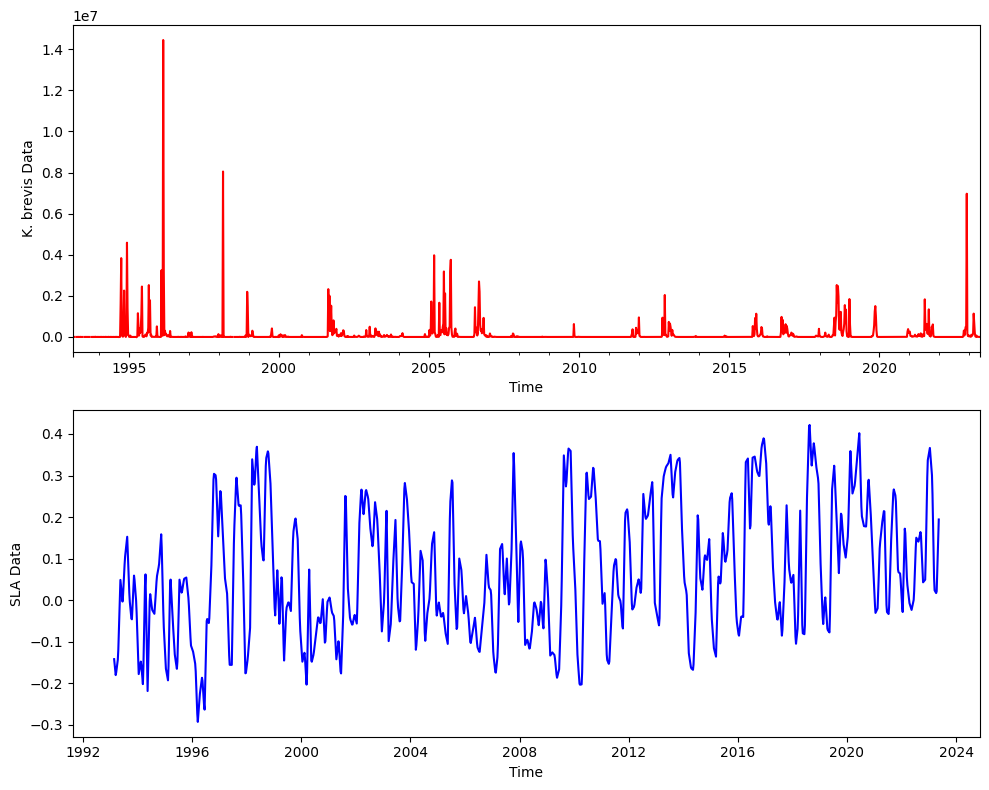

In [28]:
# Plot time series data in two subplots within the same figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot Kb_stationary data
KB_data.plot(color='red', ax=ax1)
ax1.set_ylabel('K. brevis Data')
ax1.set_xlabel('Time')

# Plot sla_stationary data
ds_TL26_HR_LowLat_mean.plot(color='blue', ax=ax2)
ax2.set_ylabel('SLA Data')
ax2.set_xlabel('Time')

plt.tight_layout();

### 4.3 Additional steps

Before we proceed with statstical analysis there could be additional considerations and steps that are method specific. For example, if we want perform cross-correlation analysis we would need to:
- Check if both time series are stationary. If they are not stationary, we may need to difference the series or transform them in some way to make them stationary.
- Detrending the data helps remove any linear trends present, allowing us to focus on the anomalies in the data.
- Series should be normalized, especially if they are in very different units or scales. This usually involves dividing by the standard deviation. We can do many more data preparation as needed. 

Here is an example of normalization

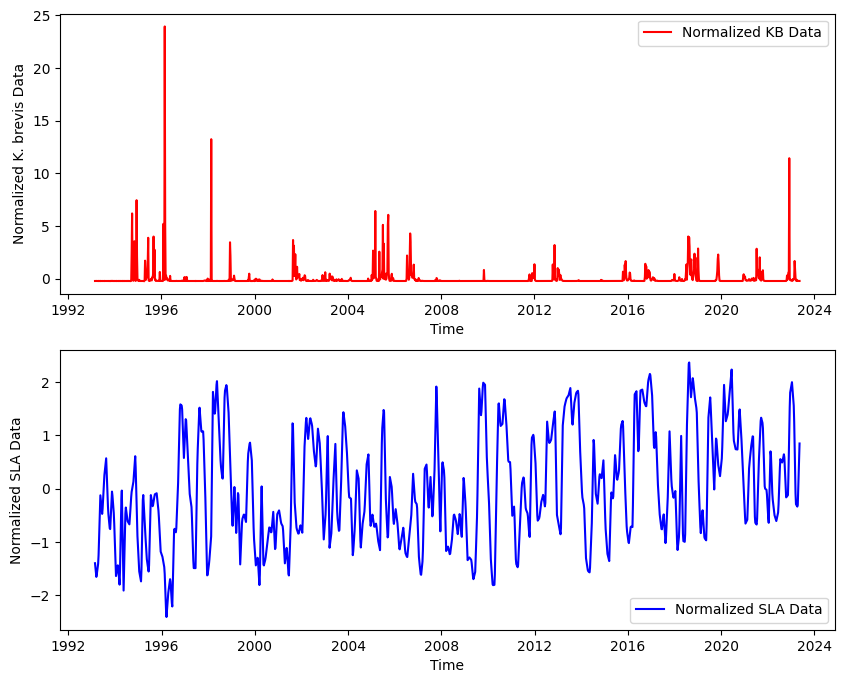

In [29]:
# Normalize both series
sla_norm = (ds_TL26_HR_LowLat_mean - ds_TL26_HR_LowLat_mean.mean()) / ds_TL26_HR_LowLat_mean.std()
red_tide_norm = (KB_data - KB_data.mean()) / KB_data.std()

# Create a single figure with two subplots for normalized data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot normalized KB data
ax1.plot(red_tide_norm.index, red_tide_norm, color='red', label='Normalized KB Data')
ax1.set_ylabel('Normalized K. brevis Data')
ax1.set_xlabel('Time')
ax1.legend();

# Plot normalized SLA data
ax2.plot(sla_norm.time, sla_norm, color='blue', label='Normalized SLA Data')
ax2.set_ylabel('Normalized SLA Data')
ax2.set_xlabel('Time')
ax2.legend();



Once we prepared your data, you can use statistical libraries like statsmodels to perform statstical analysis.